In [ ]:
from mkit.torch_support.model.GNN import GNNRegressionWithSkipConnections
from mkit.torch_support.tensor_utils import graph_x_y_split
import torch
from torch import  nn
from tqdm import  tqdm
import matplotlib.pyplot as plt
import networkx as nx
from sklearn.metrics import accuracy_score

- Artificial Dataset Generation

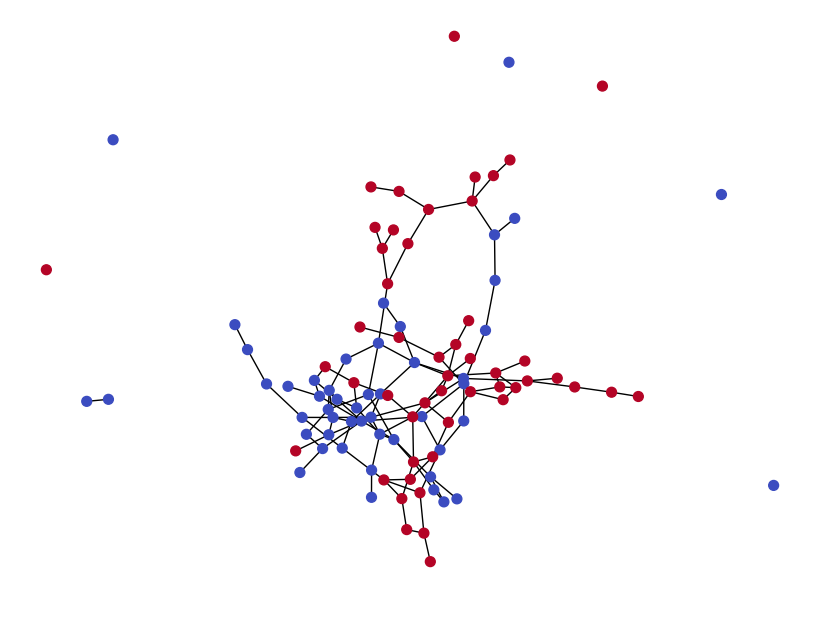

In [22]:

# Parameters
num_nodes = 100
p_intra = 0.05  # Probability of intra-community edges
p_inter = 0.005  # Probability of inter-community edges

# Create a stochastic block model graph
sizes = [50, 50]  # Two communities of 50 nodes each
probs = [[p_intra, p_inter],
         [p_inter, p_intra]]
G = nx.stochastic_block_model(sizes, probs, seed=42)

# Draw the graph
pos = nx.spring_layout(G, seed=42)
plt.figure(figsize=(8, 6))
nx.draw(G, pos, node_color=[0]*50 + [1]*50, cmap=plt.get_cmap('coolwarm'), node_size=50)
plt.show()

# Get edge list
edge_index = torch.tensor(list(G.edges()), dtype=torch.long).t().contiguous()

# Since the graph is undirected, add both directions
edge_index = torch.cat([edge_index, edge_index[[1, 0], :]], dim=1)


In [23]:
# Assign features based on community
# Community 0: [1, 0], Community 1: [0, 1]
features = []
for node in G.nodes():
    if node < 50:
        features.append([1, 0])
    else:
        features.append([0, 1])
features = torch.tensor(features, dtype=torch.float)
labels = torch.tensor([0]*50 + [1]*50, dtype=torch.long)


In [24]:
# Get edge list
edge_index = torch.tensor(list(G.edges()), dtype=torch.long).t().contiguous()

# Since the graph is undirected, add both directions
edge_index = torch.cat([edge_index, edge_index[[1, 0], :]], dim=1)


In [18]:
import numpy as np
import torch
from torch_geometric.data import Data


In [19]:
data = Data(x=features, edge_index=edge_index, y=labels)
data = graph_x_y_split(data)


In [50]:
EPOCHS = 20
# Initialize the model, optimizer, and criterion
model = GNNRegressionWithSkipConnections(2, 16, 2, 2)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()  # Ensure this matches your task

# Training loop
model.train()
for epoch in tqdm(range(EPOCHS)):
    optimizer.zero_grad()
    out = model(data)
    
    # Compute loss only on training nodes
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()

    if epoch % 20 == 0:
        # Optionally, evaluate on validation set
        model.eval()
        with torch.no_grad():
            val_out = model(data)
            val_loss = criterion(val_out[data.val_mask], data.y[data.val_mask])
        model.train()
        print(f'Epoch {epoch}, Training Loss: {loss.item():.6f}, Validation Loss: {val_loss.item():.6f}')


100%|██████████| 20/20 [00:00<00:00, 98.17it/s]

Epoch 0, Training Loss: 0.625047, Validation Loss: 0.744141


100%|██████████| 20/20 [00:00<00:00, 95.81it/s]


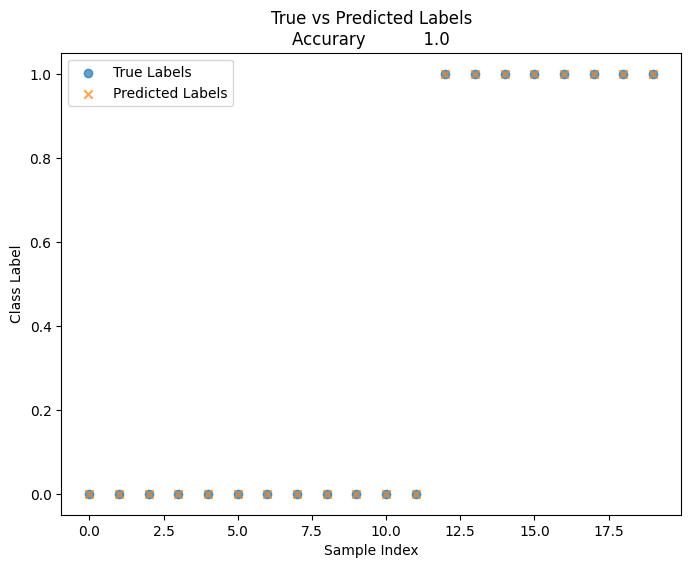

In [51]:

# After training, evaluate on the test set
model.eval()
with torch.no_grad():
    test_out = model(data)
    test_pred = test_out[data.test_mask]
    test_true = data.y[data.test_mask]

# Convert predictions to probabilities and predicted classes if needed (for classification)
predicted_classes = torch.argmax(test_pred, dim=1)  # Use softmax for probabilities if needed

# Plot predictions vs true labels (for classification)
plt.figure(figsize=(8, 6))

plt.scatter(range(len(test_true)), test_true.cpu(), label='True Labels', alpha=0.7)
plt.scatter(range(len(predicted_classes)), predicted_classes.cpu(), label='Predicted Labels', alpha=0.7, marker='x')
plt.title(f"True vs Predicted Labels\nAccurary \
          {accuracy_score(test_true.cpu(), predicted_classes.cpu())}")
plt.xlabel("Sample Index")
plt.ylabel("Class Label")
plt.legend()
plt.show()
